In [129]:
%matplotlib inline
import pandas as pd, numpy, statsmodels, bisect
from bisect import *
import scipy
from scipy import stats
import matplotlib.pyplot as plt

###Starting Values

In [130]:
# set number of buses below
number_of_buses = 3

# set number of stops
number_of_stops = 5

In [131]:
# set average speed of links in miles per hour
link_speeds_mph = [30,30,30,30,30,30]
link_speeds = [i/3600.0 for i in link_speeds_mph]

In [132]:
# set position of stops in miles
# last stop is the same as 0 (resets loop)
stop_spacing = 0.25
stop_positions = []
for i in range(number_of_stops):
    stop_positions.append((i+1)*stop_spacing)

# set buses to start evenly spaced between first and last stop
start_positions = []
start_spacing = stop_positions[-1]/number_of_buses
for i in range(number_of_buses):
    start_positions.append((i+1)*start_spacing - (start_spacing/2))

print "STARTING CONDITIONS"
print "# of buses: " + str(number_of_buses)
print "# of stops: " + str(number_of_stops)
print "link speeds array (miles per hour): " + str(link_speeds_mph)
print "link speeds array (miles per second): " + str(["{0:.5f}".format(i) for i in link_speeds])
print "stop positions (miles): " + str(stop_positions)
print "bus start positions: " + str(["{0:.2f}".format(i) for i in start_positions])

STARTING CONDITIONS
# of buses: 3
# of stops: 5
link speeds array (miles per hour): [30, 30, 30, 30, 30, 30]
link speeds array (miles per second): ['0.00833', '0.00833', '0.00833', '0.00833', '0.00833', '0.00833']
stop positions (miles): [0.25, 0.5, 0.75, 1.0, 1.25]
bus start positions: ['0.21', '0.62', '1.04']


In [133]:
# check number of stops correct
if len(stop_positions) != number_of_stops:
    print "number of stops incorrect"
else: print "number of stops OK"
    
# check number of links correct
if len(link_speeds) - 1 != number_of_stops:
    print "number of links incorrect"
else: print "number of links OK"

number of stops OK
number of links OK


### Dataframe and Variables

In [134]:
# create dataframe

df = pd.DataFrame(index = [range(0,1000)])

In [135]:
# create bus position variables

pos_vars = []
for i in range(number_of_buses):
    varname = "pos_" + str(i)
    df[varname] = 0
    pos_vars.append(varname) # this creates a list of bus position variables for indexing later
    
# create variables that record what link the bus is on

link_vars = []
for i in range(number_of_buses):
    varname = "link_" + str(i)
    df[varname] = 0
    df[varname] = df[varname].astype(int)
    link_vars.append(varname)

# create variables to keep track of bus speed between links

speed_vars = []
for i in range(number_of_buses):
    varname = "speed_" + str(i)
    df[varname] = 0
    speed_vars.append(varname)
    
# create variables to keep track of the dwelltime of each bus

dwell_vars = []
for i in range(number_of_buses):
    varname = "dwell_" + str(i)
    df[varname] = 0
    dwell_vars.append(varname)

# create variables to record how many passengers have arrived at each stop

pax_vars = []
for i in range(number_of_stops):
    varname = "pax_" + str(i)
    df[varname] = 0
    pax_vars.append(varname)    
    
# create variables to keep track of how long buses will have to wait once they arrive at each stop

wait_vars = []
for i in range(number_of_stops):
    varname = "wait_" + str(i)
    df[varname] = 0.0
    wait_vars.append(varname)

In [136]:
# results lists

spacing_vars = []
for i in range(number_of_buses):
    if i == number_of_buses -1 :
        varname = "spacing_" + str(i) + "_" + str(0)
        df[varname] = 0.0
        spacing_vars.append(varname)
    else:
        varname = "spacing_" + str(i) + "_" + str(i+1)
        df[varname] = 0.0
        spacing_vars.append(varname)

### Bus & Passenger Behavior Functions

#### Passenger Arrival Function
* Loops through each variable in pax_vars and generates new passengers through a Poisson process
* Set "lamb" as average # of passengers arriving per HOUR (as in lambda in Poisson PMF)
* Presupposes counter variable i running through dataframe row-by-row

In [137]:
def pax_arrival(lamb):
    for stop in range(len(pax_vars)):
        if i == 0: 
            df.loc[i,pax_vars[stop]] = 0
        else:
            df.loc[i,pax_vars[stop]] = df.loc[i-1,pax_vars[stop]] + numpy.random.poisson(lam=(lamb/3600.0),size=1)[0]

#### Dwelltime Function
* For each bus stop, keeps track of how much time the next bus to arrive there will have to dwell
* board_time is average time to board per passenger, in SECONDS
* Presupposes counter variable i running through dataframe row-by-row

In [138]:
def dwelltime(board_time,stddev):    
    for s in range(len(wait_vars)):
        board = numpy.random.normal(loc=board_time,scale=stddev)
        if i == 0: 
            df.loc[i,wait_vars[s]] = 0.0
        else:
            df.loc[i,wait_vars[s]] = df.loc[i,pax_vars[s]] * max(board,1.0)

In [139]:
def dwelltime_alt(normal,slow,prob):    
    for s in range(len(wait_vars)):
        if i == 0: 
            df.loc[i,wait_vars[s]] = 0.0
        else:
            board_list=[]
            for p in range(df.loc[i,pax_vars[s].astype(int)]):
                if numpy.random.binomial(1, prob) == 1:
                    board_list.append(slow)
                else:
                    board_list.append(normal)
            df.loc[i,wait_vars[s]] = sum(board_list)

#### Bus Movement Functions

In [140]:
def bus_movement_initial(bus):
    # set position using start position list
    df.loc[i,pos_vars[bus]] = start_positions[bus]

    # find link from position using "bisect" function
    df.loc[i,link_vars[bus]] = bisect_right(stop_positions,start_positions[bus])

    # find link speed from list

    # why does this become a float?
    # df.loc[i,speed_vars[bus]] = link_speeds[df.loc[i,link_vars[bus]]]
    df.loc[i,speed_vars[bus]] = link_speeds[bus]

    # set starting dwelltimes to 0 so that buses "leave" right away
    df.loc[i,dwell_vars[bus]] = 0

In [141]:
def bus_movement_conditions(bus):
    
    global prev_pos, prev_link, prev_speed, prev_dwell, reached_end, reached_stop
    
    prev_pos = df.loc[i-1,pos_vars[bus]]
    prev_link = int(df.loc[i-1,link_vars[bus]])
    prev_speed = df.loc[i-1,speed_vars[bus]]
    prev_dwell = df.loc[i-1,dwell_vars[bus]]      

    if prev_pos + prev_speed >= stop_positions[-1]:
        reached_end = True
    else:
        reached_end = False

    if prev_pos + prev_speed >= stop_positions[prev_link]:
        reached_stop = True
    else:
        reached_stop = False

In [142]:
def bus_movement_link(bus):
    # identify current link (if at stop, bus is on following link) 
    
    global current_link
    
    if reached_end == True:
        current_link = 0
        df.loc[i,link_vars[bus]] = current_link
    elif reached_stop == True:
        current_link = prev_link + 1
        df.loc[i,link_vars[bus]] = current_link  # get current link number from stop position list
    else: 
        current_link = prev_link
        df.loc[i,link_vars[bus]] = current_link

In [143]:
def bus_movement_paxcount(bus):
    
    # reset passenger count at stop to 0
    if reached_end == True:
        df.loc[i,pax_vars[current_link]] = 0  
    elif reached_stop == True:
        df.loc[i,pax_vars[current_link]] = 0

In [144]:
def bus_movement_speed(bus):
    
    # get speed from the link, generate new speed only if link updates
    if reached_end == True:
        df.loc[i,speed_vars[bus]] = link_speeds[current_link]
    elif reached_stop == True:
        df.loc[i,speed_vars[bus]] = link_speeds[current_link]
    else: 
        df.loc[i,speed_vars[bus]] = prev_speed

In [145]:
def bus_movement_dwell(bus):
    
    # WITHOUT CONTROL
    
    # if bus has arrived at a stop, generate a dwelltime
    # if bus has been at a stop, keep it at the stop until dwelltime is reached
    if reached_end == True:
        df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
    elif reached_stop == True:
        df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
    else: 
        df.loc[i,dwell_vars[bus]] = max(0, prev_dwell - 1)

In [146]:
def bus_movement_dwell_control_v2(bus):
    
    # WITH CONTROL
    
    # if bus has arrived at a stop, generate a dwelltime
    # if bus has been at a stop, keep it at the stop until dwelltime is reached
    
    if reached_end == True:
        df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
    
    # control point at stop #2
    elif (reached_stop == True) & (current_link == 2):
        
        control_point(bus)
    
    # control point at stop #4
    elif (reached_stop == True) & (current_link == 4):
        
        control_point(bus)

    elif reached_stop == True:
        df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
        
    else: 
        df.loc[i,dwell_vars[bus]] = max(0, prev_dwell - 1)

In [147]:
def control_point(bus):
    
    # determine spacing of buses ahead and behind
    s = list(df.loc[i-1,pos_vars])
    t = list(df.loc[i-1,pos_vars])
    t.remove(t[bus])
    p = df.loc[i-1,pos_vars[bus]]
    init_spacing = start_positions[1] - start_positions[0]

    if p == max(s):
        ahead_pos = min(t)
        behind_pos = max(t)
        ahead_spacing = (stop_positions[-1] - p) + ahead_pos
        behind_spacing = (p - behind_pos)
    elif p == min(s):
        ahead_pos = min(t)
        behind_pos = max(t)
        ahead_spacing = (ahead_pos - p)
        behind_spacing = (stop_positions[-1] - behind_pos) + p
    else:
        ahead_pos = max(t)
        behind_pos = min(t)
        ahead_spacing = (ahead_pos - p)
        behind_spacing = (p - behind_pos)

    # Implement controls
    
    # Hard reset: if bus ahead is less than half the initial spacing ahead, wait a specific number of seconds (currently 55s)
    if ahead_spacing < (.5 * init_spacing):
        df.loc[i,dwell_vars[bus]] = max(df.loc[i,wait_vars[current_link]], 55)
    
    # Soft reset: every time bus reaches control point, if the bus behind is more than an ideal spacing away,
    # wait the amount of time it takes to catch up the difference at link-travel-speed
    
        if behind_spacing <= init_spacing:
            df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
        else:
            catchuptime = (behind_spacing - init_spacing)*df.loc[i,speed_vars[bus]]
            df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]] + catchuptime * 1

In [148]:
def bus_movement_move(bus):
    # if bus is not at a stop, proceed at established speed

    #if prev_pos >= stop_positions[prev_link + 1]:
    #   df.loc[i,pos_vars[bus]] = df.loc[i-1,pos_vars[bus]] + df.loc[i,speed_vars[bus]]  

    if reached_end == True:
        df.loc[i,pos_vars[bus]] = 0 + ((prev_pos + prev_speed) - stop_positions[-1])
    elif df.loc[i-1,dwell_vars[bus]] <= 1 :
        df.loc[i,pos_vars[bus]] = prev_pos + prev_speed
    else: 
        df.loc[i,pos_vars[bus]] = prev_pos

In [149]:
def bus_movement():
    for bus in range(number_of_buses):
        if i == 0:
            bus_movement_initial(bus)
            
        else:
            bus_movement_conditions(bus)
            bus_movement_link(bus)             
            bus_movement_paxcount(bus)
            bus_movement_speed(bus)
            if control == True:
                bus_movement_dwell_control_v2(bus)
            else:
                bus_movement_dwell(bus)
            bus_movement_move(bus)

### Analytics

In [150]:
def spacing():
    for pair in spacing_vars:
        a = df.loc[i,"pos_" + pair.split("_")[1]]
        b = df.loc[i,"pos_" + pair.split("_")[2]]
        val = min(
            abs(a-b),
            ((stop_positions[-1] - max(a,b)) + min(a,b))
            )
        df.loc[i,pair] = val

In [151]:
def bunching():
    bunch_list = []
    for pair in spacing_vars:
        bunch_list.append(df.loc[i,pair] < 0.03)
    if any(bunch_list):
        df.loc[i,"bunching"] = 1.0
    else:
        df.loc[i,"bunching"] = 0.0

### Control

In [152]:
# set control!!
control = True

### Simulation and Plots

In [153]:
# Run all the functions 
# Loop over every row in the dataframe


for i in range(len(df)):
    
    # 100 pax per hour
    pax_arrival(lamb = 200)
    
    # 2 seconds per boarding pax
    dwelltime(board_time = 2,stddev=1)
#     dwelltime_alt(2,20,.5)
    
    bus_movement()
    
    # performance analytics
    spacing()
    bunching()

### Analysis

In [154]:
# TOTAL PAX WAIT
analytics_list=[]
wait_list = []
for v in pax_vars:
    wait_list.append(df[v].sum())

print "TOTAL WAIT: " + str(sum(wait_list))
analytics_list.append(sum(wait_list))

TOTAL WAIT: 7955.0


In [155]:
if len(df.bunching[df.bunching == 1]) > 0:
    print "TIME OF FIRST BUNCH: " + str(min(df.bunching[df.bunching == 1].index))
    analytics_list.append(min(df.bunching[df.bunching == 1].index))
else:
    analytics_list.append("no bunch")

In [156]:
loops = 0
for i in range(1,len(df)):
    for bus in pos_vars:
        if (df.loc[i-1,bus] <= 1.23) and (df.loc[i,bus] >= 1.23):
            loops += 1

print "ROUTES COMPLETED: " + str(loops)
analytics_list.append(loops)

ROUTES COMPLETED: 18


In [157]:
print analytics_list

[7955.0, 'no bunch', 18]


#### Time-Space Diagram

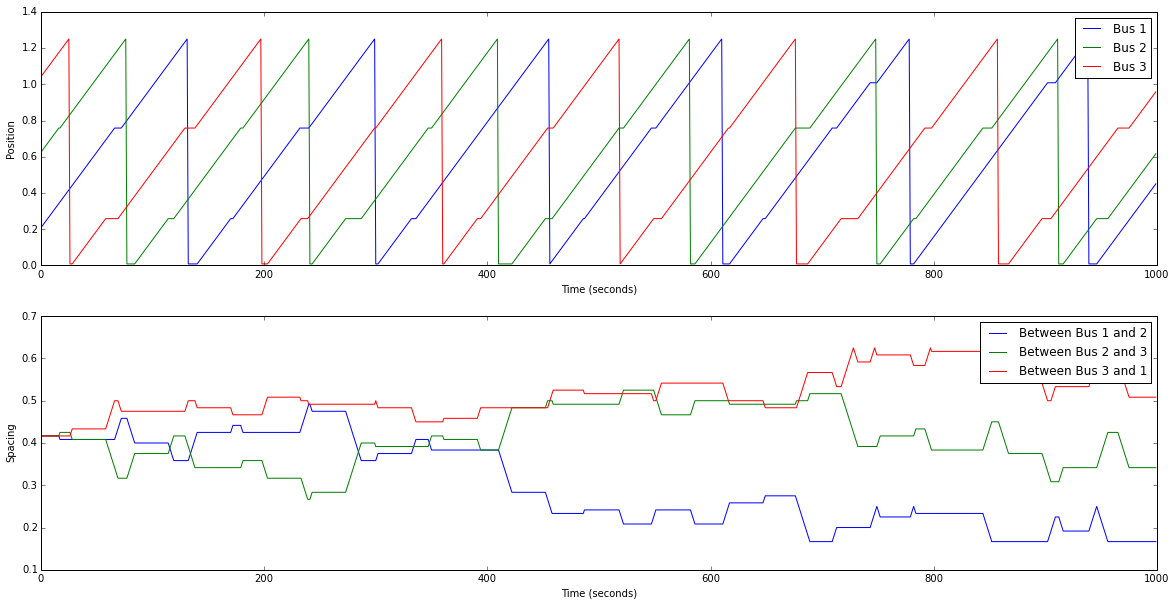

In [158]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for i in pos_vars:
    plt.plot(df[i])
plt.ylabel('Position')
plt.xlabel('Time (seconds)')
plt.legend(["Bus 1","Bus 2","Bus 3"])

plt.subplot(2,1,2)
for i in spacing_vars:
    plt.plot(df[i])
plt.ylabel('Spacing')
plt.xlabel('Time (seconds)')
plt.legend(["Between Bus 1 and 2","Between Bus 2 and 3","Between Bus 3 and 1"])

plt.show()

#### Cumulative Arrival Curves

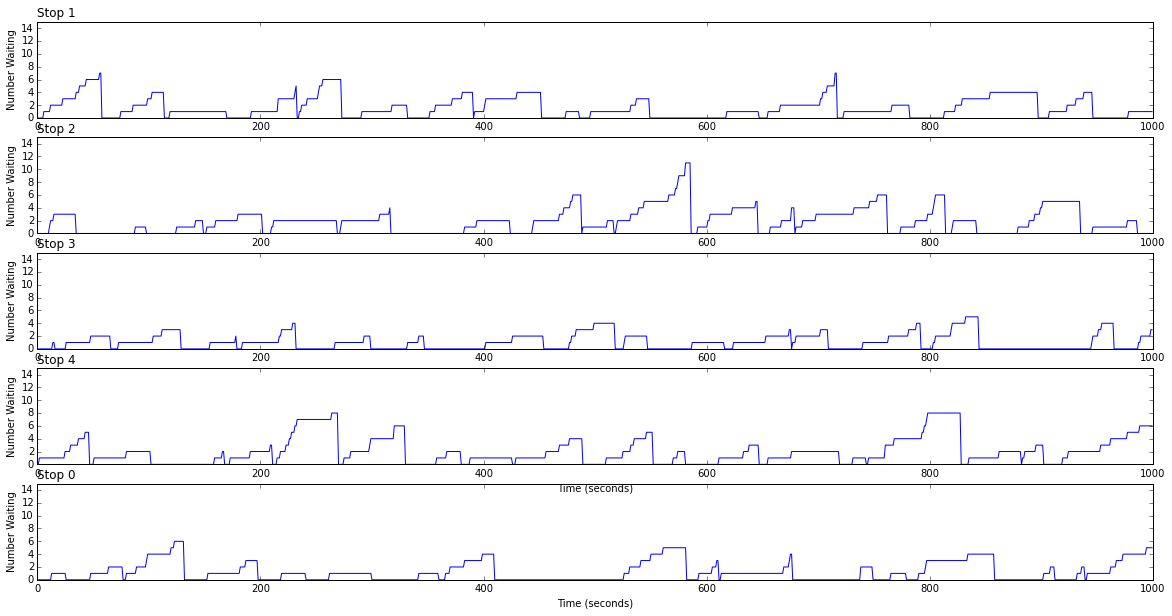

In [159]:
plt.figure(figsize=(20,10))
for i in pax_vars:
    plt.subplot(len(pax_vars),1,pax_vars.index(i))
    plt.title("Stop " + str(pax_vars.index(i)), loc="left")
    plt.plot(df[i])
    plt.ylabel('Number Waiting')
    plt.ylim(ymin = 0, ymax = 15)
    plt.xlabel('Time (seconds)')
plt.show()

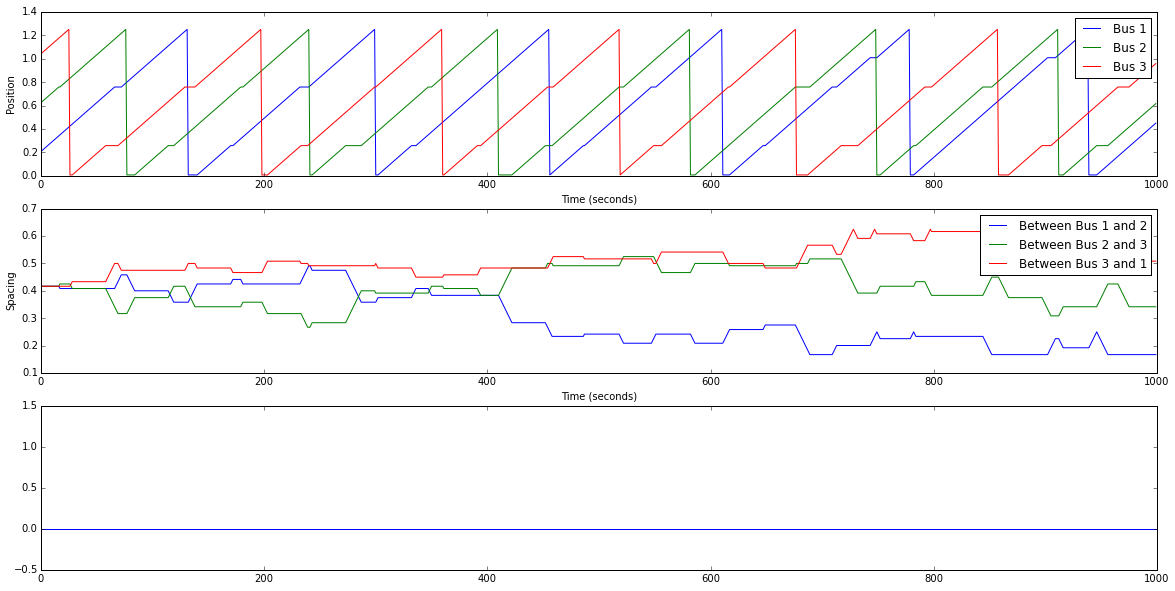

In [160]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
for i in pos_vars:
    plt.plot(df[i])
plt.ylabel('Position')
plt.xlabel('Time (seconds)')
plt.legend(["Bus 1","Bus 2","Bus 3"])


plt.subplot(3,1,2)
for i in spacing_vars:
    plt.plot(df[i])
plt.ylabel('Spacing')
plt.xlabel('Time (seconds)')
plt.legend(["Between Bus 1 and 2","Between Bus 2 and 3","Between Bus 3 and 1"])


plt.subplot(3,1,3)
plt.plot(df.bunching)
plt.ylim(ymin = -0.5, ymax = 1.5)

plt.show()